In [1]:
from nemo.collections.tts.models import MagpieTTSModel
from nemo.collections.tts.data.text_to_speech_dataset import MagpieTTSDataset, DatasetSample
from omegaconf.omegaconf import OmegaConf, open_dict
import torch
import os
import soundfile as sf
from IPython.display import display, Audio
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

[NeMo W 2025-07-04 04:54:18 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
      from .autonotebook import tqdm as notebook_tqdm
    
[NeMo W 2025-07-04 04:54:23 nemo_logging:405] Please use the EncDecSpeakerLabelModel instead of this model. EncDecClassificationModel model is kept for backward compatibility with older models.


### Checkpoint Paths

In [2]:
hparams_file = "/datap/misc/experiment_checkpoints/JuneRelease/cer_ssim_priornull_hparams.yaml"
checkpoint_file = "/datap/misc/experiment_checkpoints/JuneRelease/cer_ssim_priornull_epoch1.ckpt"
# codecmodel_path = "/datap/misc/checkpoints/AudioCodec_21Hz_no_eliz.nemo"
codecmodel_path = "/datap/misc/checkpoints/21fps_causal_codecmodel.nemo"


# Temp out dir for saving audios
out_dir = "/datap/misc/t5tts_inference_notebook_samples"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Load Model

In [3]:
def update_config(model_cfg, codecmodel_path, legacy_codebooks=False):
    ''' helper function to rename older yamls from t5 to magpie '''
    model_cfg.codecmodel_path = codecmodel_path
    if hasattr(model_cfg, 'text_tokenizer'):
        # Backward compatibility for models trained with absolute paths in text_tokenizer
        model_cfg.text_tokenizer.g2p.phoneme_dict = "scripts/tts_dataset_files/ipa_cmudict-0.7b_nv23.01.txt"
        model_cfg.text_tokenizer.g2p.heteronyms = "scripts/tts_dataset_files/heteronyms-052722"
        model_cfg.text_tokenizer.g2p.phoneme_probability = 1.0
    model_cfg.train_ds = None
    model_cfg.validation_ds = None
    if "t5_encoder" in model_cfg:
        model_cfg.encoder = model_cfg.t5_encoder
        del model_cfg.t5_encoder
    if "t5_decoder" in model_cfg:
        model_cfg.decoder = model_cfg.t5_decoder
        del model_cfg.t5_decoder
    if hasattr(model_cfg, 'decoder') and hasattr(model_cfg.decoder, 'prior_eps'):
        # Added to prevent crash after removing arg from transformer_2501.py in https://github.com/blisc/NeMo/pull/56
        del model_cfg.decoder.prior_eps
    if hasattr(model_cfg, 'use_local_transformer') and model_cfg.use_local_transformer:
        # For older checkpoints trained with a different parameter name
        model_cfg.local_transformer_type = "autoregressive"
        del model_cfg.use_local_transformer

    if legacy_codebooks:
        # Added to address backward compatibility arising from
        #  https://github.com/blisc/NeMo/pull/64
        print("WARNING: Using legacy codebook indices for backward compatibility. Should only be used with old checkpoints.")
        num_audio_tokens_per_codebook = model_cfg.num_audio_tokens_per_codebook
        model_cfg.forced_num_all_tokens_per_codebook = num_audio_tokens_per_codebook
        model_cfg.forced_audio_eos_id = num_audio_tokens_per_codebook - 1
        model_cfg.forced_audio_bos_id = num_audio_tokens_per_codebook - 2
        if model_cfg.model_type == 'decoder_context_tts':
            model_cfg.forced_context_audio_eos_id = num_audio_tokens_per_codebook - 3
            model_cfg.forced_context_audio_bos_id = num_audio_tokens_per_codebook - 4
            model_cfg.forced_mask_token_id = num_audio_tokens_per_codebook - 5
        else:
            model_cfg.forced_context_audio_eos_id = num_audio_tokens_per_codebook - 1
            model_cfg.forced_context_audio_bos_id = num_audio_tokens_per_codebook - 2
    if hasattr(model_cfg, 'sample_rate'):
        # This was removed from the config and is now in the model class
        sample_rate = model_cfg.sample_rate
        del model_cfg.sample_rate
    else:
        sample_rate = None

    # model_cfg.make_prior_window_strict = False
    return model_cfg, sample_rate
    

model_cfg = OmegaConf.load(hparams_file).cfg

with open_dict(model_cfg):
    model_cfg, cfg_sample_rate = update_config(model_cfg, codecmodel_path, False)


model = MagpieTTSModel(cfg=model_cfg)
print("Loading weights from checkpoint")
ckpt = torch.load(checkpoint_file, weights_only=False)
model.load_state_dict(ckpt['state_dict'])
print("Loaded weights.")

model.use_kv_cache_for_inference = True

model.cuda()
model.eval()

[NeMo W 2025-07-04 04:54:25 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      dataset_type: tarred_vocoder
      dataset_args:
        dataset_meta:
          mls_english:
            manifest_path: /lustre/fsw/portfolios/llmservice/projects/llmservice_nemo_speechlm/data/TTS/mls_english/filtered_22khz/tarred_audio/train_manifest.json
            tar_filepath: /lustre/fsw/portfolios/llmservice/projects/llmservice_nemo_speechlm/data/TTS/mls_english/filtered_22khz/tarred_audio/audio_{0..1999}.tar
          cv:
            manifest_path: /lustre/fsw/portfolios/llmservice/projects/llmservice_nemo_speechlm/data/TTS/commonvoice13/22khz/tarred_audio/train_manifest.json
            tar_filepath: /lustre/fsw/portfolios/llmservice/projects/llmservice_nemo_speechlm/data/TTS/commonvoice13/22khz/tarred_audio/audio_{0..279}.tar

[NeMo I 2025-07-04 04:54:25 nemo_logging:393] Vector quantizer does not support commit loss.
[NeMo I 2025-07-04 04:54:26 nemo_logging:393] PADDING: 1
[NeMo I 2025-07-04 04:54:27 nemo_logging:393] PADDING: 1
[NeMo I 2025-07-04 04:54:27 nemo_logging:393] PADDING: 1
[NeMo I 2025-07-04 04:54:27 nemo_logging:393] PADDING: 1
[NeMo I 2025-07-04 04:54:27 nemo_logging:393] PADDING: 1
[NeMo I 2025-07-04 04:54:27 nemo_logging:393] PADDING: 1
Speaker encoder loaded and frozen !!
[NeMo I 2025-07-04 04:54:32 nemo_logging:393] Model AudioCodecModel was successfully restored from /datap/misc/checkpoints/21fps_causal_codecmodel.nemo.


[NeMo W 2025-07-04 04:54:32 nemo_logging:405] `<class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2025-07-04 04:54:33 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-07-04 04:54:33 nemo_logging:405] `<class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'>` is experimental and not ready for production yet. Use at your own risk.


[NeMo I 2025-07-04 04:54:35 nemo_logging:393] Local transformer type: none
Loading weights from checkpoint
Loaded weights.


MagpieTTSModel(
  (_codec_model): AudioCodecModel(
    (audio_encoder): HiFiGANEncoder(
      (pre_conv): Conv1dNorm(
        (conv): ParametrizedConv1d(
          1, 24, kernel_size=(7,), stride=(1,), padding=(3,), padding_mode=replicate
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation): Identity()
      )
      (activations): ModuleList(
        (0-4): 5 x CodecActivation(
          (activation): LeakyReLU(negative_slope=0.01)
        )
      )
      (down_sample_conv_layers): ModuleList(
        (0): Conv1dNorm(
          (conv): ParametrizedConv1d(
            24, 48, kernel_size=(4,), stride=(2,), padding=(1,), padding_mode=replicate
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): _WeightNorm()
              )
            )
          )
          (activation): Identity()
        )
        (1): Conv

### Initialize Dataset class and helper functions

In [4]:
context_duration_min = model.cfg.get('context_duration_min', 5.0)
context_duration_max = model.cfg.get('context_duration_max', 5.0)
test_dataset = MagpieTTSDataset(
    dataset_meta={},
    sample_rate=model.sample_rate,
    min_duration=0.5,
    max_duration=20,
    codec_model_samples_per_frame=model.codec_model_samples_per_frame,
    bos_id=model.bos_id,
    eos_id=model.eos_id,
    context_audio_bos_id=model.context_audio_bos_id,
    context_audio_eos_id=model.context_audio_eos_id,
    audio_bos_id=model.audio_bos_id,
    audio_eos_id=model.audio_eos_id,
    num_audio_codebooks=model.num_audio_codebooks,
    prior_scaling_factor=None,
    load_cached_codes_if_available=False,
    dataset_type='test',
    tokenizer_config=None,
    load_16khz_audio=model.model_type == 'single_encoder_sv_tts',
    use_text_conditioning_tokenizer=model.use_text_conditioning_encoder,
    pad_context_text_to_max_duration=model.pad_context_text_to_max_duration,
    context_duration_min=context_duration_min,
    context_duration_max=context_duration_max,
)
test_dataset.text_tokenizer = model.tokenizer
test_dataset.text_conditioning_tokenizer = model.text_conditioning_tokenizer



def get_audio_duration(file_path):
    with sf.SoundFile(file_path) as audio_file:
        # Calculate the duration
        duration = len(audio_file) / audio_file.samplerate
        return duration

def create_record(text, context_audio_filepath=None, context_text=None):
    dummy_audio_fp = os.path.join(out_dir, "dummy_audio.wav")
    dummy_audio = sf.write(dummy_audio_fp, np.zeros(22050 * 3), 22050)  # 3 seconds of silence
    record = {
        'audio_filepath' : dummy_audio_fp,
        'duration': 3.0,
        'text': text,
        'speaker': "dummy",
    }
    if context_text is not None:
        assert context_audio_filepath is None
        record['context_text'] = context_text
    else:
        assert context_audio_filepath is not None
        record['context_audio_filepath'] = context_audio_filepath
        record['context_audio_duration'] = get_audio_duration(context_audio_filepath)
    
    return record

### Set transcript and context pairs to test

In [5]:
import pprint
# Change sample text and prompt audio/text here

 
 # Let me confirm one, one, one, one, one, x, two, two two, two two, two, one, two, four, four, h t t p, four, five, six, seven, eight. Is that correct?
 # Let me confirm S D S D two, two, two, two, one, two, four, four, h t t p, four, five, six, seven, eight. Is that correct?
 # His phone number is one one one one, nine nine nine nine nine, nine nine, nine, right

audio_base_dir = "/"
test_entries = [
    create_record(
        text=" Let me confirm one, one, one, one, one, x, two, two two, two two, two, one, two, four, four, h t t p, four, five, six, seven, eight. Is that correct?",
        # context_audio_filepath="/datap/misc/LibriTTSfromNemo/LibriTTS/test-clean/8230/279154/8230_279154_000004_000009.wav",
        context_audio_filepath="/datap/misc/Datasets/riva/Rodney/22khz/WIZWIKI/RODNEY_WIZWIKI_009244.wav"
    ),
    create_record(
        text=" Let me confirm S D S D two, two, two, two, one, two, four, four, h t t p, four, five, six, seven, eight. Is that correct?",
        # context_audio_filepath="/datap/misc/LibriTTSfromNemo/LibriTTS/test-clean/8230/279154/8230_279154_000004_000009.wav",
        context_audio_filepath="/datap/misc/Datasets/riva/Rodney/22khz/WIZWIKI/RODNEY_WIZWIKI_009244.wav"
    ),
    create_record(
        text=" one, two, two, three, three, three, four, four, four, four, five, five, five, five, five, six, six, six, six, six, six.",
        # context_audio_filepath="/datap/misc/LibriTTSfromNemo/LibriTTS/test-clean/8230/279154/8230_279154_000004_000009.wav",
        context_audio_filepath="/datap/misc/Datasets/riva/Rodney/22khz/WIZWIKI/RODNEY_WIZWIKI_009244.wav"
    ),
    create_record(
        text=" Let me confirm that number: two, one, two, four, four, four, five, six, seven, eight. Is that correct?",
        # context_audio_filepath="/datap/misc/LibriTTSfromNemo/LibriTTS/test-clean/8230/279154/8230_279154_000004_000009.wav",
        context_audio_filepath="/datap/misc/Datasets/riva/Rodney/22khz/WIZWIKI/RODNEY_WIZWIKI_009244.wav"
    ),
    create_record(
        text=" His phone number is one one one one, nine nine nine nine nine, nine nine, nine, right",
        # context_audio_filepath="/datap/misc/LibriTTSfromNemo/LibriTTS/test-clean/8230/279154/8230_279154_000004_000009.wav",
        context_audio_filepath="/datap/misc/Datasets/riva/Rodney/22khz/WIZWIKI/RODNEY_WIZWIKI_009244.wav"
    ),
    
]

data_samples = []
for entry in test_entries:
    dataset_sample = DatasetSample(
        dataset_name="sample",
        manifest_entry=entry,
        audio_dir=audio_base_dir,
        feature_dir=audio_base_dir,
        text=entry['text'],
        speaker=None,
        speaker_index=0,
        tokenizer_names=["english_phoneme"], # Change this for multilingual: "english_phoneme", "spanish_phoneme", "english_chartokenizer", "german_chartokenizer".. 
    )
    data_samples.append(dataset_sample)
    
test_dataset.data_samples = data_samples

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    collate_fn=test_dataset.collate_fn,
    num_workers=0,
    shuffle=False
)

### Generate With Prior

Processing batch 0 out of 5
Decoding timestep 0
Decoding timestep 20
Decoding timestep 40
Decoding timestep 60
Decoding timestep 80
Decoding timestep 100
Decoding timestep 120
Decoding timestep 140
Decoding timestep 160
Decoding timestep 180
Decoding timestep 200
Decoding timestep 220
Decoding timestep 240
Decoding timestep 260
Decoding timestep 280
End detected for item 0 at timestep 292
All ends reached
generation time 7.949263095855713
{'batch_size': 1,
 'max_frames_generated': 293,
 'rtf': 1.9604623935783512,
 'time_to_first_prediction': 0.33730602264404297,
 'tts_generation_time': 6.362949848175049,
 'tts_generation_time_per_frame': 0.021716552382849995}
 Let me confirm one, one, one, one, one, x, two, two two, two two, two, one, two, four, four, h t t p, four, five, six, seven, eight. Is that correct?
Prior Used? True
use_local_transformer False


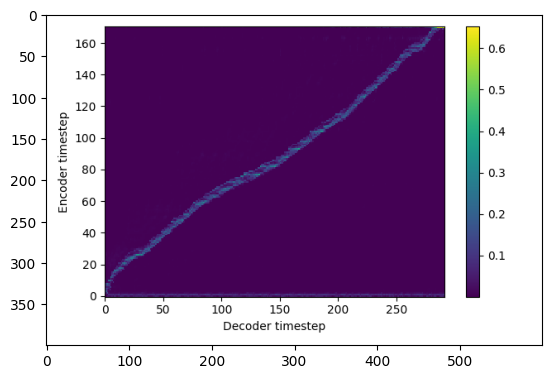

------------------------------------
------------------------------------
Processing batch 1 out of 5
Decoding timestep 0
Decoding timestep 20
Decoding timestep 40
Decoding timestep 60
Decoding timestep 80
Decoding timestep 100
Decoding timestep 120
Decoding timestep 140
Decoding timestep 160
Decoding timestep 180
Decoding timestep 200
Decoding timestep 220
End detected for item 0 at timestep 239
All ends reached
generation time 6.189146518707275
{'batch_size': 1,
 'max_frames_generated': 240,
 'rtf': 2.3918213719213104,
 'time_to_first_prediction': 0.07421660423278809,
 'tts_generation_time': 4.527295112609863,
 'tts_generation_time_per_frame': 0.01886372963587443}
 Let me confirm S D S D two, two, two, two, one, two, four, four, h t t p, four, five, six, seven, eight. Is that correct?
Prior Used? True
use_local_transformer False


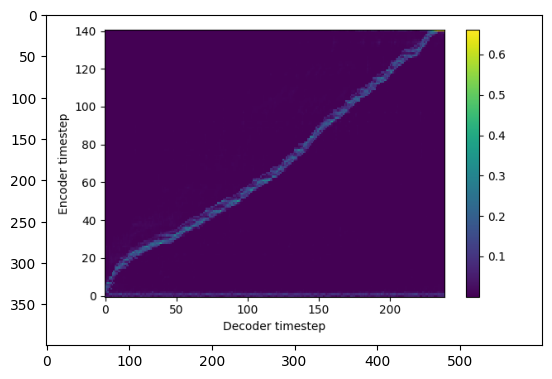

------------------------------------
------------------------------------
Processing batch 2 out of 5
Decoding timestep 0
Decoding timestep 20
Decoding timestep 40
Decoding timestep 60
Decoding timestep 80
Decoding timestep 100
Decoding timestep 120
Decoding timestep 140
Decoding timestep 160
Decoding timestep 180
Decoding timestep 200
Decoding timestep 220
Decoding timestep 240
Decoding timestep 260
End detected for item 0 at timestep 263
All ends reached
generation time 6.025923013687134
{'batch_size': 1,
 'max_frames_generated': 264,
 'rtf': 2.4079279597159697,
 'time_to_first_prediction': 0.08361077308654785,
 'tts_generation_time': 4.956067323684692,
 'tts_generation_time_per_frame': 0.01877298228668444}
 one, two, two, three, three, three, four, four, four, four, five, five, five, five, five, six, six, six, six, six, six.
Prior Used? True
use_local_transformer False


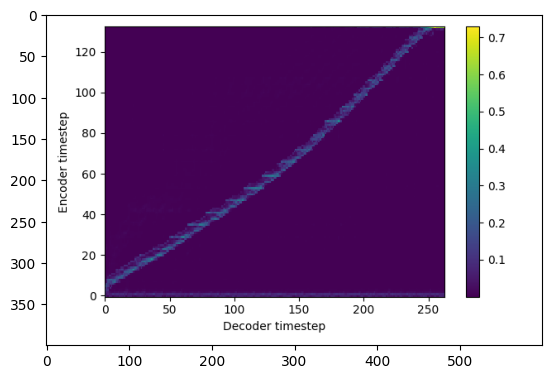

------------------------------------
------------------------------------
Processing batch 3 out of 5
Decoding timestep 0
Decoding timestep 20
Decoding timestep 40
Decoding timestep 60
Decoding timestep 80
Decoding timestep 100
Decoding timestep 120
Decoding timestep 140
Decoding timestep 160
Decoding timestep 180
Decoding timestep 200
End detected for item 0 at timestep 208
All ends reached
generation time 5.00596809387207
{'batch_size': 1,
 'max_frames_generated': 209,
 'rtf': 2.4034109160101567,
 'time_to_first_prediction': 0.07296371459960938,
 'tts_generation_time': 3.9052975177764893,
 'tts_generation_time_per_frame': 0.01868563405634684}
 Let me confirm that number: two, one, two, four, four, four, five, six, seven, eight. Is that correct?
Prior Used? True
use_local_transformer False


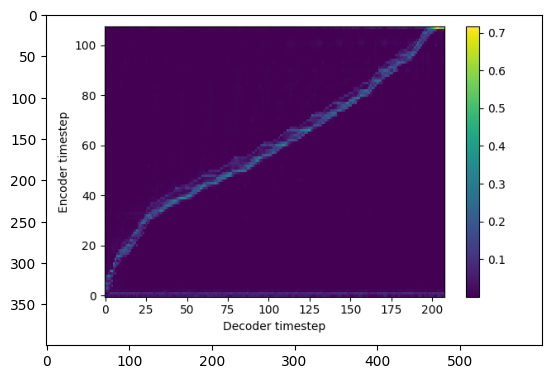

------------------------------------
------------------------------------
Processing batch 4 out of 5
Decoding timestep 0
Decoding timestep 20
Decoding timestep 40
Decoding timestep 60
Decoding timestep 80
Decoding timestep 100
Decoding timestep 120
End detected for item 0 at timestep 125
All ends reached
generation time 3.387202739715576
{'batch_size': 1,
 'max_frames_generated': 126,
 'rtf': 2.331584397419663,
 'time_to_first_prediction': 0.06587958335876465,
 'tts_generation_time': 2.382443428039551,
 'tts_generation_time_per_frame': 0.01890828117491707}
 His phone number is one one one one, nine nine nine nine nine, nine nine, nine, right
Prior Used? True
use_local_transformer False


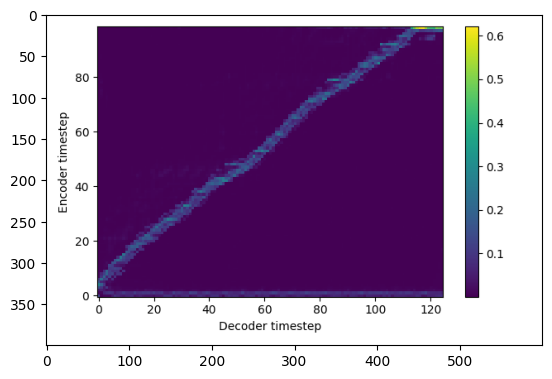

------------------------------------
------------------------------------


In [6]:
import matplotlib.pyplot as plt

item_idx = 0
for bidx, batch in enumerate(test_data_loader):
    print("Processing batch {} out of {}".format(bidx, len(test_data_loader)))
    model.decoder.reset_cache(use_cache=True)
    batch_cuda ={}
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch_cuda[key] = batch[key].cuda()
        else:
            batch_cuda[key] = batch[key]
    import time
    st = time.time()
    
    for _ in range(1):
        for use_local_transformer_for_inference in [False]:
            for apply_prior in [True]:
                predicted_audio, predicted_audio_lens, _, _, rtf_metrics, cross_attn_np, all_heads_attn_np = model.infer_batch(
                    batch_cuda, 
                    max_decoder_steps=430, 
                    temperature=0.6,
                    topk=80,
                    use_cfg=True,
                    cfg_scale=2.5,
                    prior_epsilon=0.0,
                    lookahead_window_size=4,
                    return_cross_attn_probs=True,
                    estimate_alignment_from_layers=[4,6,10],
                    apply_attention_prior=apply_prior,
                    apply_prior_to_layers=[4,5,6,7,8,9,10,11],
                    compute_all_heads_attn_maps=True,
                    start_prior_after_n_audio_steps=0,
                    use_local_transformer_for_inference=use_local_transformer_for_inference
                )
                print("generation time", time.time() - st)
                pprint.pprint(rtf_metrics)
                for idx in range(predicted_audio.size(0)):
                    predicted_audio_np = predicted_audio[idx].float().detach().cpu().numpy()
                    predicted_audio_np = predicted_audio_np[:predicted_audio_lens[idx]]
                    audio_path = os.path.join(out_dir, f"predicted_audio_{item_idx}.wav")
                    sf.write(audio_path, predicted_audio_np, model.sample_rate)
                    print(test_entries[bidx]['text'])
                    print("Prior Used?", apply_prior)
                    print("use_local_transformer", use_local_transformer_for_inference)
                    display(Audio(audio_path))
                    item_idx += 1
                    plt.imshow(cross_attn_np[idx])
                    plt.show()
                    # for hidx, head_cross_attn in enumerate(all_heads_attn_np[idx]):
                    #     layer_num = hidx // model.cfg.decoder.xa_n_heads
                    #     head_num = hidx % model.cfg.decoder.xa_n_heads
                    #     print("item, layer, head", idx, layer_num, head_num)
                    #     plt.imshow(all_heads_attn_np[idx][hidx])
                    #     plt.show()

                print("------------------------------------")
                print("------------------------------------")